## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [13]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i , n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [15]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3, 0.8]
redice_lr_patient = [10, 25]

In [16]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor,
                                  min_lr=1e-12,
                                  monitor="val_loss",
                                  patience=reduce_patient,
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0723 20:50:24.397791  6208 deprecation_wrapper.py:119] From C:\Users\shoey\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 20:50:24.494796  6208 deprecation_wrapper.py:119] From C:\Users\shoey\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 10


W0723 20:50:24.819815  6208 deprecation_wrapper.py:119] From C:\Users\shoey\Anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 20:50:24.827816  6208 deprecation_wrapper.py:119] From C:\Users\shoey\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0723 20:50:24.923821  6208 deprecation.py:323] From C:\Users\shoey\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

50000/50000 [==============================] - 4s 88us/step - loss: 1.2414 - acc: 0.5672 - val_loss: 1.4702 - val_acc: 0.4844
Epoch 15/25
50000/50000 [==============================] - 4s 86us/step - loss: 1.2212 - acc: 0.5757 - val_loss: 1.4662 - val_acc: 0.4865
Epoch 16/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.2000 - acc: 0.5822 - val_loss: 1.4737 - val_acc: 0.4864
Epoch 17/25
50000/50000 [==============================] - 4s 74us/step - loss: 1.1816 - acc: 0.5907 - val_loss: 1.4578 - val_acc: 0.4877
Epoch 18/25
50000/50000 [==============================] - 4s 84us/step - loss: 1.1621 - acc: 0.5975 - val_loss: 1.4632 - val_acc: 0.4843
Epoch 19/25
50000/50000 [==============================] - 4s 88us/step - loss: 1.1449 - acc: 0.6030 - val_loss: 1.4433 - val_acc: 0.4923
Epoch 20/25
50000/50000 [==============================] - 5s 92us/step - loss: 1.1260 - acc: 0.6122 - val_loss: 1.4532 - val_acc: 0.4905
Epoch 21/25
50000/50000 [=====================

Epoch 2/25
50000/50000 [==============================] - 5s 90us/step - loss: 1.7678 - acc: 0.3826 - val_loss: 1.8480 - val_acc: 0.3614
Epoch 3/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.6380 - acc: 0.4251 - val_loss: 1.7260 - val_acc: 0.3954
Epoch 4/25
50000/50000 [==============================] - 5s 91us/step - loss: 1.5628 - acc: 0.4509 - val_loss: 1.6527 - val_acc: 0.4186
Epoch 5/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.5097 - acc: 0.4694 - val_loss: 1.6198 - val_acc: 0.4356
Epoch 6/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.4639 - acc: 0.4862 - val_loss: 1.5795 - val_acc: 0.4457
Epoch 7/25
50000/50000 [==============================] - 5s 95us/step - loss: 1.4263 - acc: 0.5001 - val_loss: 1.5535 - val_acc: 0.4535
Epoch 8/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.3905 - acc: 0.5113 - val_loss: 1.5575 - val_acc: 0.4522
Epoch 9/25
50000/50000 [=================

Epoch 25/25
50000/50000 [==============================] - 5s 99us/step - loss: 0.3344 - acc: 0.9100 - val_loss: 1.6940 - val_acc: 0.5033
Numbers of exp: 5, reduce_factor: 0.30, reduce_patient: 25
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_laye

50000/50000 [==============================] - 5s 98us/step - loss: 0.9450 - acc: 0.6699 - val_loss: 1.5236 - val_acc: 0.4755
Epoch 13/25
50000/50000 [==============================] - 5s 101us/step - loss: 0.9135 - acc: 0.6819 - val_loss: 1.4713 - val_acc: 0.4890
Epoch 14/25
50000/50000 [==============================] - 5s 98us/step - loss: 0.8745 - acc: 0.6989 - val_loss: 1.4719 - val_acc: 0.4911
Epoch 15/25
50000/50000 [==============================] - 5s 97us/step - loss: 0.8435 - acc: 0.7100 - val_loss: 1.5803 - val_acc: 0.4717
Epoch 16/25
50000/50000 [==============================] - 5s 100us/step - loss: 0.8143 - acc: 0.7207 - val_loss: 1.5243 - val_acc: 0.4913
Epoch 17/25
50000/50000 [==============================] - 5s 97us/step - loss: 0.7822 - acc: 0.7332 - val_loss: 1.4473 - val_acc: 0.5034
Epoch 18/25
50000/50000 [==============================] - 5s 99us/step - loss: 0.7498 - acc: 0.7470 - val_loss: 1.5680 - val_acc: 0.4763
Epoch 19/25
50000/50000 [===================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.8348 - acc: 0.3638 - val_loss: 2.1987 - val_acc: 0.2614
Epoch 2/25
50000/50000 [==============================] - 5s 97us/step - loss: 1.5311 - acc: 0.4601 - val_loss: 2.1326 - val_acc: 0.3457
Epoch 3/25
50000/50000 [==============================] - 5s 98us/step - loss: 1.4225 - acc: 0.4960 - val_loss: 2.1911 - val_acc: 0.2918
Epoch 4/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.3412 - acc: 0.5266 - val_loss: 2.1049 - val_acc: 0.3309
Epoch 5/25
50000/50000 [==============================] - 5s 101us/step - loss: 1.2822 - acc: 0.5478 - val_loss: 2.7262 - val_acc: 0.2500
Epoch 6/25
50000/50000 [==============================] - 5s 103us/step - loss: 1.2220 - acc: 0.5686 - val_loss: 1.9477 - val_acc: 0.3370
Epoch 7/25
50000/50000 [==============================] - 5s 94us/step - loss: 1.1695 - acc: 0.5866 - val_loss: 2.3107 - val_

50000/50000 [==============================] - 3s 61us/step - loss: 0.7000 - acc: 0.7674 - val_loss: 1.7924 - val_acc: 0.4407
Epoch 24/25
50000/50000 [==============================] - 3s 62us/step - loss: 0.6755 - acc: 0.7756 - val_loss: 1.8960 - val_acc: 0.4279
Epoch 25/25
50000/50000 [==============================] - 3s 62us/step - loss: 0.6502 - acc: 0.7850 - val_loss: 1.7114 - val_acc: 0.4533
Numbers of exp: 10, reduce_factor: 0.80, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_31 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_lay

Epoch 11/25
50000/50000 [==============================] - 4s 90us/step - loss: 1.0282 - acc: 0.6437 - val_loss: 1.7262 - val_acc: 0.4286
Epoch 12/25
50000/50000 [==============================] - 5s 94us/step - loss: 0.9956 - acc: 0.6544 - val_loss: 1.7380 - val_acc: 0.4306
Epoch 13/25
50000/50000 [==============================] - 5s 92us/step - loss: 0.9661 - acc: 0.6683 - val_loss: 1.6292 - val_acc: 0.4422
Epoch 14/25
50000/50000 [==============================] - 5s 93us/step - loss: 0.9331 - acc: 0.6796 - val_loss: 1.7267 - val_acc: 0.4504
Epoch 15/25
50000/50000 [==============================] - 5s 95us/step - loss: 0.9060 - acc: 0.6914 - val_loss: 1.7958 - val_acc: 0.4069
Epoch 16/25
50000/50000 [==============================] - 4s 87us/step - loss: 0.8775 - acc: 0.7006 - val_loss: 1.6782 - val_acc: 0.4534
Epoch 17/25
50000/50000 [==============================] - 4s 86us/step - loss: 0.8496 - acc: 0.7102 - val_loss: 1.9545 - val_acc: 0.3911
Epoch 18/25
50000/50000 [=========

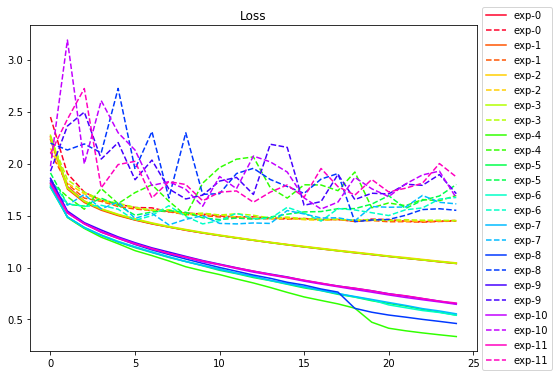

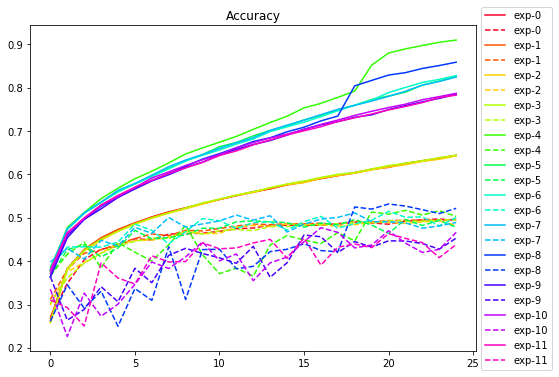

In [17]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()